# Baseline Stock Forecasting Model

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ta
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Download Data

In [2]:
df = yf.download('AAPL', period='5y', auto_adjust=False)
df.columns = df.columns.droplevel(1)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-11-20,114.224899,117.339996,118.769997,117.290001,118.639999,73604300
2020-11-23,110.827545,113.849998,117.620003,113.750000,117.180000,127959300
2020-11-24,112.112495,115.169998,115.849998,112.589996,113.910004,113874200
2020-11-25,112.949646,116.029999,116.750000,115.169998,115.550003,76499200
2020-11-27,113.494812,116.589996,117.489998,116.220001,116.570000,46691300


## Train and test split


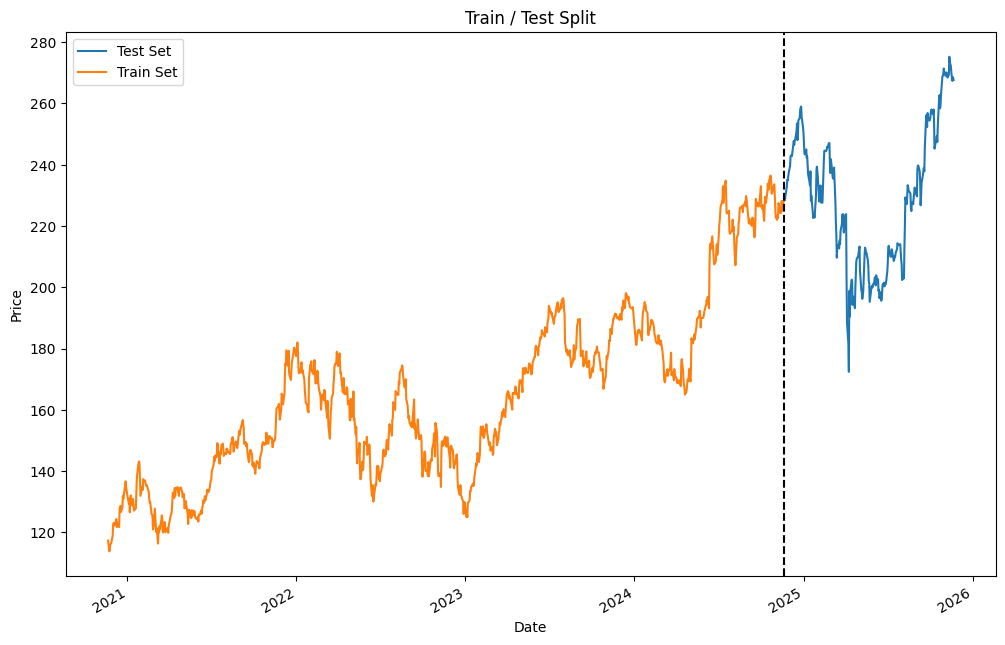

In [3]:
ratio_test_train = 0.8
train = df.loc[df.index < df.index[int(len(df) * ratio_test_train)]]    
test = df.loc[df.index >= df.index[int(len(df) * ratio_test_train)]]

fig, axs = plt.subplots(figsize=(12, 8))
test['Close'].plot(ax=axs, xlabel='Date', ylabel='Price', title='Test Set')
train['Close'].plot(ax=axs, xlabel='Date', ylabel='Price', title='Train Set')
axs.legend(['Test Set', 'Train Set'])   
axs.axvline(df.index[int(len(df) * ratio_test_train)], color='k', linestyle='--')
plt.title('Train / Test Split')
plt.show()

## Feature Engineering

In [4]:
def create_features(df):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['MA30'] = df['Close'].rolling(30).mean()

    # --- RSI ---
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

    # SROCH (9,6)
    # Criação do indicador
    from ta.momentum import StochasticOscillator
    stoch = StochasticOscillator(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        window=9,        # %K período
        smooth_window=6  # suavização
    )

    # %K suavizado (linha principal)
    df['STOCH_K'] = stoch.stoch()
    df['STOCH_D'] = stoch.stoch_signal()

    return df

df = create_features(df)
df.dropna(inplace=True)
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume,Return,MA5,MA10,MA30,RSI,STOCH_K,STOCH_D
Date,,,,,,,,,,,,,
2025-11-14,272.410004,272.410004,275.959991,269.600006,271.049988,47431300,-0.001978,272.702002,271.098001,262.705667,64.835823,56.797598,52.702486
2025-11-17,267.459991,267.459991,270.489990,265.730011,268.820007,45018300,-0.018171,272.308002,270.939001,263.064666,54.352371,15.770103,51.988471
2025-11-18,267.440002,267.440002,270.709991,265.320007,269.989990,45677300,-0.000075,270.746002,270.679001,263.429999,54.314179,18.629123,50.305624
2025-11-19,268.559998,268.559998,272.209991,265.500000,265.529999,40424500,0.004188,269.764001,270.520999,263.779999,56.172456,28.470904,41.500648
2025-11-20,267.630005,267.630005,275.429993,266.359985,270.809998,31386876,-0.003463,268.700000,270.307001,264.233000,54.201012,20.298740,34.013557


<Axes: xlabel='Price'>

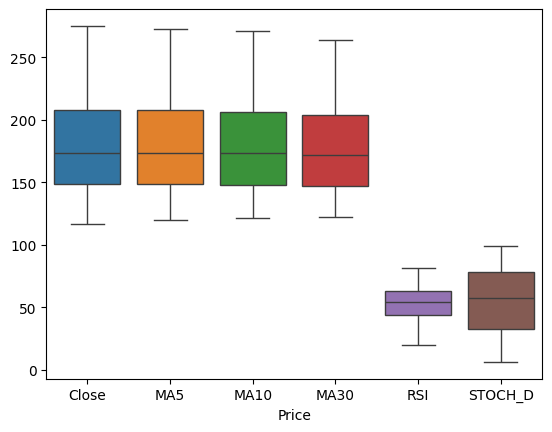

In [5]:
features = ['Close', 'MA5', 'MA10', 'MA30', 'RSI', 'STOCH_D']
sns.boxplot(data=df[features])

In [6]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Return,MA5,MA10,MA30,RSI,STOCH_K,STOCH_D
Date,,,,,,,,,,,,,
2021-01-05,127.531998,131.009995,131.740005,128.429993,128.889999,97664900,0.012364,132.339999,132.143001,125.294667,58.538361,35.328308,61.855213
2021-01-06,123.239052,126.599998,131.050003,126.379997,127.720001,155088000,-0.033662,130.686000,131.980001,125.603333,48.587580,1.772774,46.263939
2021-01-07,127.444366,130.919998,131.630005,127.860001,128.360001,109578200,0.034123,130.125999,131.884000,126.172333,56.405306,36.583420,39.953526
2021-01-08,128.544403,132.050003,132.630005,130.229996,132.429993,105158200,0.008631,129.998000,131.993000,126.735000,58.195961,45.689022,36.410163
2021-01-11,125.555878,128.979996,130.169998,128.500000,129.190002,100384500,-0.023249,129.911998,131.693999,127.166667,51.952460,20.950840,29.862848


## Create the model

In [9]:
train = create_features(train)
test = create_features(test)


# Create the target variable (next day's close price)
train['Target'] = train['Close'].shift(-1)
test['Target'] = test['Close'].shift(-1)

# Features list remains the same
features = ['Close', 'Return', 'MA5', 'MA10', 'MA30', 'RSI', 'STOCH_D']

# Drop the last row which now contains NaN in the 'Target' column
train_clean = train.dropna()
test_clean = test.dropna()

# Split X and y - they are now guaranteed to be the same length
X_train = train_clean[features]
y_train = train_clean['Target'] 
X_test = test_clean[features]
y_test = test_clean['Target'] 

# Check the shapes to confirm alignment before training
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (974, 7), y_train shape: (974,)


In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:27.98305	validation_1-rmse:63.77593
[1]	validation_0-rmse:27.71072	validation_1-rmse:63.26615
[2]	validation_0-rmse:27.44111	validation_1-rmse:62.77350
[3]	validation_0-rmse:27.17418	validation_1-rmse:62.27427
[4]	validation_0-rmse:26.91016	validation_1-rmse:61.78019
[5]	validation_0-rmse:26.64850	validation_1-rmse:61.30275
[6]	validation_0-rmse:26.38946	validation_1-rmse:60.81888
[7]	validation_0-rmse:26.13302	validation_1-rmse:60.35135
[8]	validation_0-rmse:25.87911	validation_1-rmse:59.87757
[9]	validation_0-rmse:25.62799	validation_1-rmse:59.40868
[10]	validation_0-rmse:25.37911	validation_1-rmse:58.95558
[11]	validation_0-rmse:25.13276	validation_1-rmse:58.49641
[12]	validation_0-rmse:24.88883	validation_1-rmse:58.05226
[13]	validation_0-rmse:24.64737	validation_1-rmse:57.60263
[14]	validation_0-rmse:24.40847	validation_1-rmse:57.15736
[15]	validation_0-rmse:24.17188	validation_1-rmse:56.72731
[16]	validation_0-rmse:23.93752	validation_1-rmse:56.28967
[17]	va

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


## Feature Importance

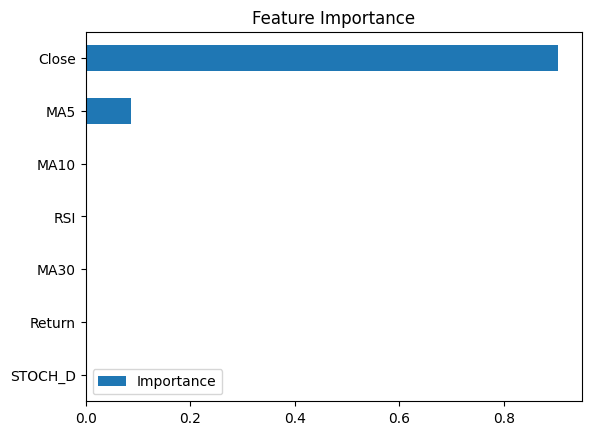

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['Importance'])
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [23]:
# 1. Prediction: Use the aligned X_test
predictions = reg.predict(X_test) 
test_clean['prediction'] = predictions

df = df.merge(test_clean[['prediction']], how='left', left_index=True, right_index=True)

/tmp/ipykernel_1415131/1954496309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean['prediction'] = predictions


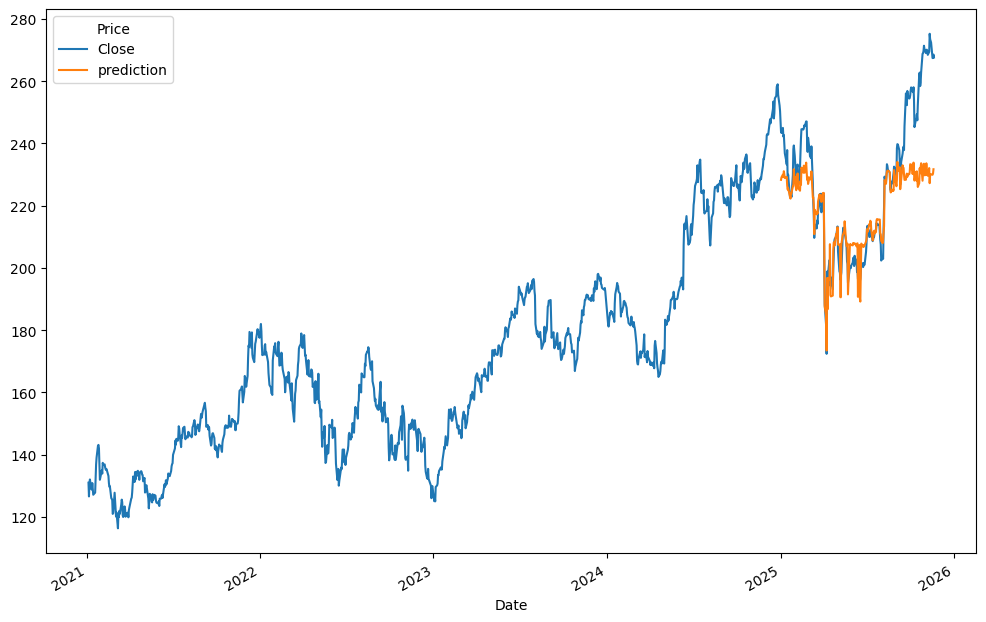

MSE: 250.88260693394008
MAE: 10.944678229254645
R2: 0.5162562281576755


In [26]:
df[['Close', 'prediction']].plot(figsize=(12, 8))
plt.show()
## Evaluation
print(f"MSE: {mean_squared_error(y_test, test_clean['prediction'])}")
print(f"MAE: {mean_absolute_error(y_test, test_clean['prediction'])}")
print(f"R2: {r2_score(y_test, test_clean['prediction'])}")

In [29]:
import numpy as np
score = np.sqrt(mean_squared_error(test_clean['Target'], test_clean['prediction']))
print(f"RMSE: {score}")

RMSE: 15.839274192144666


/tmp/ipykernel_1415131/751357624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean['error'] = np.abs(test_clean['prediction'] - test_clean['Target'])


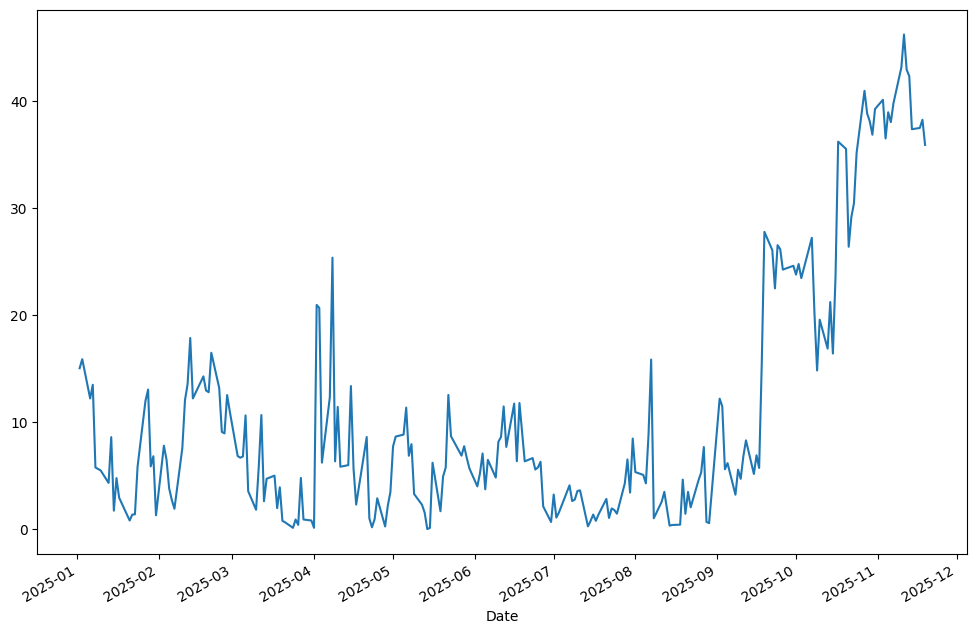

In [30]:
test_clean['error'] = np.abs(test_clean['prediction'] - test_clean['Target'])
test_clean['error'].plot(figsize=(12, 8))
plt.show()



## Save model 

In [31]:

import pickle

# Save the model to a file
with open('baseline_model.pkl', 'wb') as f:
    pickle.dump(reg, f)

